# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,BX-E,no-book,21883,25523
1,BX-E,ambiguous,4209,31204
2,BX-E,no-author-rec,6875,8759
3,BX-E,female,38089,138864
4,BX-E,unknown,17003,27577


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ,217900.0,491600.0,17825.0,239646.0,141262.0,220524.0,936338.0,2265095.0
BX-E,38089.0,56451.0,4209.0,17003.0,6875.0,6548.0,21883.0,151058.0
BX-I,67153.0,98050.0,7141.0,34792.0,14003.0,13046.0,44067.0,278252.0
GR-E,175738.0,279480.0,11650.0,96500.0,30131.0,757989.0,NaN,1351488.0
GR-I,177361.0,282888.0,11759.0,98281.0,30847.0,768007.0,NaN,1369143.0
LOC-MDS,666633.0,2212568.0,54206.0,1219145.0,272587.0,842797.0,NaN,5267936.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,4352195.0,6623262.0,564273.0,2096628.0,737698.0,3573926.0,4510112.0
BX-E,138864.0,185730.0,31204.0,27577.0,8759.0,9505.0,25523.0
BX-I,391575.0,469588.0,78247.0,78104.0,23301.0,25904.0,62527.0
GR-E,34260862.0,34487783.0,8761723.0,3927468.0,502325.0,13871849.0,NaN
GR-I,75245333.0,70337154.0,14207710.0,10382962.0,1421006.0,38505184.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.096199,0.217033,0.007869,0.105800,0.062365,0.097358,0.413377
BX-E,0.252148,0.373704,0.027863,0.112559,0.045512,0.043348,0.144865
BX-I,0.241339,0.352378,0.025664,0.125038,0.050325,0.046886,0.158371
GR-E,0.130033,0.206794,0.008620,0.071403,0.022295,0.560855,NaN
GR-I,0.129542,0.206617,0.008589,0.071783,0.022530,0.560940,NaN
LOC-MDS,0.126545,0.420007,0.010290,0.231427,0.051745,0.159986,NaN


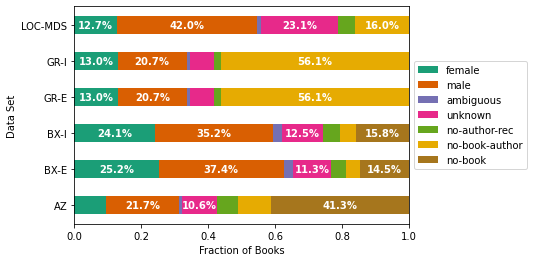

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.096199,0.217033,0.007869,0.105800,0.573099
BX-E,0.252148,0.373704,0.027863,0.112559,0.233725
BX-I,0.241339,0.352378,0.025664,0.125038,0.255581
GR-E,0.130033,0.206794,0.008620,0.071403,0.583150
GR-I,0.129542,0.206617,0.008589,0.071783,0.583470
LOC-MDS,0.126545,0.420007,0.010290,0.231427,0.211731


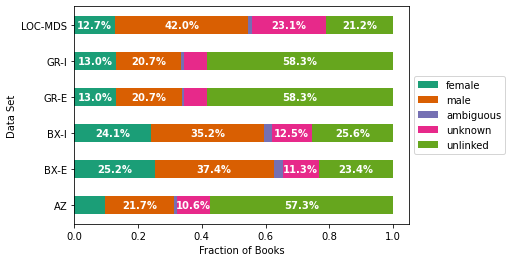

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

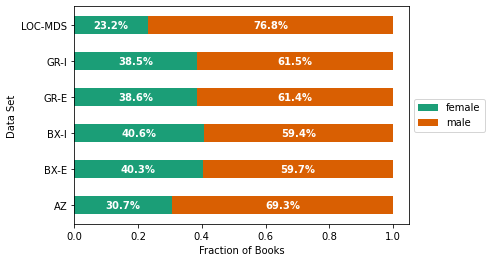

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.193792,0.294916,0.025126,0.093357,0.032848,0.159138,0.200823
BX-E,0.325085,0.434800,0.073050,0.064559,0.020505,0.022252,0.059750
BX-I,0.346758,0.415842,0.069291,0.069165,0.020634,0.022939,0.055371
GR-E,0.357584,0.359953,0.091447,0.040991,0.005243,0.144782,NaN
GR-I,0.358142,0.334780,0.067624,0.049419,0.006763,0.183271,NaN


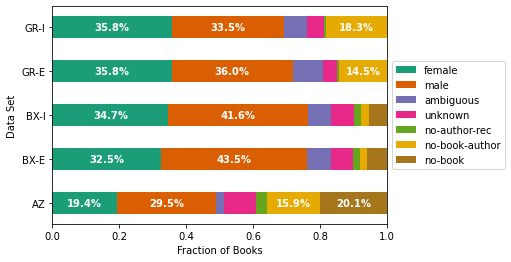

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.193792,0.294916,0.025126,0.093357,0.392809
BX-E,0.325085,0.434800,0.073050,0.064559,0.102507
BX-I,0.346758,0.415842,0.069291,0.069165,0.098944
GR-E,0.357584,0.359953,0.091447,0.040991,0.150025
GR-I,0.358142,0.334780,0.067624,0.049419,0.190035


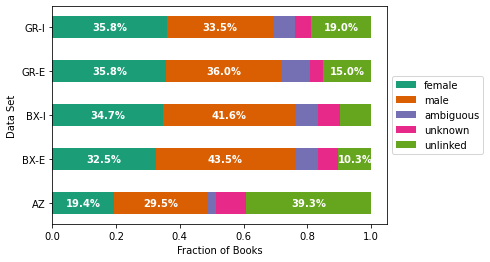

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

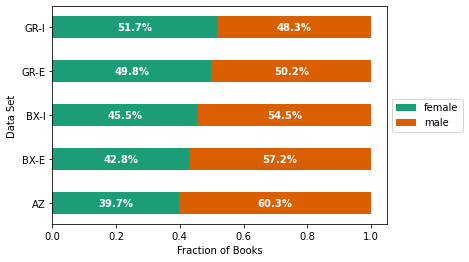

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ         0.321101
BX-E       0.653716
BX-I       0.619381
GR-E       0.345447
GR-I       0.344747
LOC-MDS    0.556842
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')